#  TensorFlow Revision: Level 1 Capstone - Brain Tumor MRI Classification

## 1. Project Overview
Welcome to the **Grand Finale of Level 1** in the TensorFlow Revision series!
We have covered the basics of Tensors, Neural Networks, and Image Processing. Now, we put everything together in this **Capstone Project**.

In this notebook, we move from simple toy datasets to a critical, real-world task: **Multi-Class Medical Image Classification**. We will build a Convolutional Neural Network (CNN) from scratch to diagnose brain tumors from MRI scans.

---

## 2. The Dataset
We are using the **Brain Tumor MRI Dataset** from Kaggle. This dataset consists of **7,023** magnetic resonance imaging (MRI) scans classified into four distinct categories:

1.  **Glioma:** A type of tumor that occurs in the brain and spinal cord.
2.  **Meningioma:** A tumor that forms on membranes that cover the brain and spinal cord.
3.  **Pituitary:** A tumor that forms in the pituitary gland at the base of the brain.
4.  **No Tumor:** Healthy brain scans.

🔗 **Dataset Link:** [Brain Tumor MRI Data on Kaggle](https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data)

---

## 3. Level 1 Objectives Accomplished
By completing this project, we demonstrate mastery of the following Level 1 concepts:

* **End-to-End Pipeline:** Loading data efficiently using `tf.keras.utils.image_dataset_from_directory`.
* **Preprocessing:** Rescaling images and handling multi-class labels (One-Hot Encoding).
* **Custom CNN Architecture:** Designing a model with multiple `Conv2D` and `MaxPooling` blocks.
* **Training Dynamics:** Understanding Epochs, Batch Size, and the `Adam` optimizer.
* **Performance Analysis:** interpreting Accuracy/Loss curves and Confusion Matrices.
* **Inference:** Using the trained model to predict unseen images.

**Next Stop:** Level 2 (Advanced Computer Vision & Transfer Learning).

# 1. Import Libraries
We start by importing the necessary libraries to build our Deep Learning pipeline:
* **`os`**: To navigate the file system and handle file paths.
* **`numpy`**: For numerical operations and array manipulations.
* **`random`**: To select random images for visualization later.
* **`BytesIO`**: To handle image file streams during upload.
* **`tensorflow`**: The core framework for building and training the neural network.
* **`matplotlib.pyplot`**: To plot images and training graphs (accuracy/loss).
* **`ipywidgets`**: To create interactive elements like the file uploader.

In [1]:
import os
import numpy as np
import random
from io import BytesIO
import tensorflow as tf
import matplotlib.pyplot as plt
from ipywidgets import widgets

# 2. Mount Google Drive
Since our dataset is stored in Google Drive, we need to "mount" it.
This connects your personal Drive storage to this Colab notebook, allowing the code to read the MRI images directly as if they were on a local hard disk.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Define Dataset Path & Verify Classes
Here, we define the main directory path where the dataset is located.
We also print the contents of this directory using `os.listdir()`. This is a crucial check to:
1.  Confirm the path is correct.
2.  Automatically see the class names (labels) which should be: `['glioma', 'meningioma', 'notumor', 'pituitary']`.

In [3]:
DATA_PATH = "/content/drive/MyDrive/MRI Data/brain-tumor-mri-dataset"
print(os.listdir(DATA_PATH))

['pituitary', 'meningioma', 'notumor', 'glioma']


# 4. Initialize Hyperparameters & Load Training Data
In this cell, we set up the training pipeline:

* **Hyperparameters**:
    * **`img_size=(224, 224)`**: We resize all images to a fixed square size. This is required because Neural Networks expect fixed-size inputs.
    * **`Batch_size=32`**: The model will process 32 images at a time. This balances memory usage and training speed.

* **`image_dataset_from_directory`**: This powerful Keras function loads images from disk, resizes them, and creates batches automatically.
    * **`validation_split=0.2`**: We reserve 20% of the data for validation (testing) and keep 80% for training.
    * **`subset="training"`**: Specifies that this dataset is for training.
    * **`seed=123`**: **Critical!** We set a random seed to ensure that the random split is identical for both training and validation sets, preventing data leakage (meaning a single image won't appear in both sets).
    * **`label_mode="categorical"`**: Since we have 4 classes (Multi-class), the labels are converted to one-hot encoded vectors (e.g., `[0, 0, 1, 0]`).

In [4]:
img_size=(224, 224)
Batch_size=32

train_dir=tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=Batch_size,
    label_mode="categorical"
)

Found 7153 files belonging to 4 classes.
Using 5723 files for training.


# 5. Load Validation Data
Here we load the remaining 20% of the data to be used for validation.
The validation set is used to evaluate the model's performance on "unseen" data after each epoch.

* **`subset="validation"`**: We explicitly ask for the validation portion of the split.
* **Note**: We must use the **same seed (`123`)** and **same image size** as the training set to ensure consistency.

In [5]:
valid_dir=tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=Batch_size,
    label_mode="categorical"
)

Found 7153 files belonging to 4 classes.
Using 1430 files for validation.


# 6. Data Normalization (Rescaling)
Neural Networks perform best when the input values are small and centered around zero.
Raw images have pixel values ranging from **0 to 255**. Feeding these large integers directly can make training unstable and slow.

* **`Rescaling(1./255)`**: This layer mathematically divides every pixel by 255.
    * Input: `[0, 255]` (Integer)
    * Output: `[0.0, 1.0]` (Float)
* **`.map()`**: We apply this transformation to the entire dataset pipeline. It happens "on the fly" as images are loaded.

In [6]:
rescalyer_layer=tf.keras.layers.Rescaling(1./255)
train_dir_rescaled=train_dir.map(lambda image, label: (rescalyer_layer(image), label))
valid_dir_rescaled=valid_dir.map(lambda image, label: (rescalyer_layer(image), label))

# 7. Configure Dataset for Performance (ETL Pipeline)
Here, we optimize the I/O pipeline to ensure the GPU never waits for data. We use `tf.data` API for asynchronous loading:

1.  **`cache()`**: Stores the images in RAM after the first epoch. This makes subsequent epochs incredibly fast since the data doesn't need to be re-read from Google Drive every time.
2.  **`shuffle(buffer_size=1000)`**: Randomizes the order of images in the training batch. This prevents the model from learning the sequence of the data (e.g., memorizing that all "Glioma" images come first) and helps it generalize better.
3.  **`prefetch(buffer_size=tf.data.AUTOTUNE)`**: Allows the CPU to prepare the *next* batch of data while the GPU is still training on the *current* batch. This parallel processing significantly reduces training time.

In [7]:
SHUFFLE_BUFFER_SIZE=1000
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

final_train_data=(
    train_dir_rescaled
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

final_valid_data=(
    valid_dir_rescaled
    .cache()
    .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
)

# 8. Define the CNN Architecture
We build the Convolutional Neural Network (CNN) structure here.
The architecture consists of **4 Convolutional Blocks** followed by **Fully Connected Layers**.

### **Feature Extraction (The "Eyes"):**
1.  **Block 1 & 2 (Low-Level Features):** We use **16 filters** in the first two layers. These detect simple patterns like edges and corners.
2.  **Block 3 & 4 (High-Level Features):** We increase the filters to **32**. These layers combine simple features to detect more complex shapes (like tumor boundaries).
3.  **MaxPooling:** Applied after every convolution to reduce the image size progressively, making the model faster and more efficient.

### **Classification (The "Brain"):**
* **Flatten:** Converts the final 2D feature maps into a 1D list.
* **Dense (256 & 64):** Two hidden layers to process the information deeply.
* **Output Layer:** **4 neurons** with **Softmax** activation to output the probability for each of the 4 tumor classes (`glioma`, `meningioma`, `notumor`, `pituitary`).

In [8]:
model=tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),

    tf.keras.layers.Conv2D(16, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
])

# 9. Model Summary & Architecture Breakdown
The `model.summary()` method gives us a detailed blueprint of our neural network.
Let's analyze why the image size shrinks layer by layer.

### **The Mystery of the Shrinking Image: Why 224 $\rightarrow$ 222?**
You might notice that our input image is **224x224**, but the first `Conv2D` output is **222x222**. Why did we lose 2 pixels?

This happens because of the **Convolution Operation** (Valid Padding):
1.  **The Filter:** We use a **3x3** filter kernel.
2.  **The Process:** To calculate the value of a pixel, the 3x3 filter needs to sit on top of the image.
3.  **The Edge Problem:** When the filter is at the very edge of the image, it hangs over the border. Since we didn't add padding (zeros around the image), the filter cannot center itself on the edge pixels.
4.  **The Math:**
    $$\text{Output Size} = \text{Input Size} - \text{Filter Size} + 1$$
    $$222 = 224 - 3 + 1$$
    
    *So, we lose 1 pixel from the left, 1 from the right, 1 from the top, and 1 from the bottom.*

### **Layer-by-Layer Walkthrough:**

1.  **`conv2d` (Conv2D):**
    * Input: $224 \times 224$
    * Filter: $3 \times 3$
    * Output: **$222 \times 222$** (with 16 distinct feature maps).

2.  **`max_pooling2d` (MaxPooling):**
    * Input: $222 \times 222$
    * Operation: Takes the max value from every $2 \times 2$ window.
    * Math: Divides dimensions by 2.
    * Output: **$111 \times 111$**.

3.  **`conv2d_1` (Second Conv):**
    * Input: $111 \times 111$
    * Filter: $3 \times 3$
    * Output: $111 - 3 + 1 =$ **$109 \times 109$**.

4.  **`flatten`:**
    * It unrolls the 3D volume into a 1D vector.
    * Calculation: $12 \times 12 \times 32 = \mathbf{4608}$.

**Total Parameters:** The model has about **1.2 Million parameters** (weights and biases) that it needs to learn during training.

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,268 (4.63 MB)

 Trainable params: 1,213,268 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

# 10. Compile the Model: Setting the Rules of Learning
Before the training starts, we need to configure *how* the model will learn. This is done using the `compile` method.

* **`loss='categorical_crossentropy'`**:
    * This is the "Scoreboard" that tells the model how bad its predictions are.
    * We use **Categorical Crossentropy** because we are doing **Multi-class Classification** (4 classes) and our labels are one-hot encoded (e.g., `[0, 1, 0, 0]`).
    * *Goal:* The model tries to minimize this value (get it close to 0).

* **`optimizer='adam'`**:
    * **Adam (Adaptive Moment Estimation)** is the algorithm that adjusts the weights of the neurons to reduce the loss.
    * It is smart and adapts the learning rate automatically, making it the industry standard for most CNN tasks.

* **`metrics=['accuracy']`**:
    * While the model minimizes "Loss" (math), we humans care about "Accuracy" (percentage).
    * This tracks what percentage of MRI scans were correctly classified during training.

In [10]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)


# 11. Train the Model: The Learning Phase
This is where the magic happens! The `fit()` function connects our data to the model and starts the training loop.

* **`final_train_data`**: The pipeline of training images we prepared earlier.
* **`epochs=20`**:
    * An **Epoch** is one complete pass through the entire training dataset (all images).
    * We repeat this 20 times. In each epoch, the model updates its weights to improve accuracy.
* **`validation_data=final_valid_data`**:
    * After every epoch, the model is tested on this separate dataset that it has *never seen before*.
    * This helps us monitor if the model is **Overfitting** (memorizing the training data but failing on new data).

### **Understanding the Output Logs:**
* **`loss` vs `val_loss`**: Training loss vs Validation loss. Ideally, both should go down.
* **`accuracy` vs `val_accuracy`**: Training accuracy vs Validation accuracy. Ideally, both should go up.
* **Note on Speed:** Notice how the first epoch takes longer (e.g., 833s) while subsequent epochs are super fast (e.g., 4s). This is thanks to the **`.cache()`** function we added earlier!

In [11]:
history=model.fit(
    final_train_data,
    epochs=20,
    validation_data=final_valid_data,
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 833s 976ms/step - accuracy: 0.5920 - loss: 0.8998 - val_accuracy: 0.8084 - val_loss: 0.4634
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8546 - loss: 0.3793 - val_accuracy: 0.8406 - val_loss: 0.3929
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9112 - loss: 0.2438 - val_accuracy: 0.9168 - val_loss: 0.2460
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9529 - loss: 0.1510 - val_accuracy: 0.9301 - val_loss: 0.2229
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9645 - loss: 0.0967 - val_accuracy: 0.9441 - val_loss: 0.1780
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9764 - loss: 0.0643 - val_accuracy: 0.9552 - val_loss: 0.1724
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9859 - loss: 0.0371 - val_accuracy: 0.9580 - val_loss: 0.1551
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9914 - loss: 0.0270 - val_a

# 12. Visualize Performance: The Accuracy Plot
Training logs are useful, but a graph tells the full story instantly.
Here, we extract the data stored in the `history` object to visualize how the model improved over time.

### **What are we plotting?**
1.  **Training Accuracy (Blue Line):** How well the model is learning from the images it *sees* (the study material).
2.  **Validation Accuracy (Orange Line):** How well the model performs on images it has *never seen* (the exam).

### **How to Interpret the Graph:**
* **Ideal Scenario:** Both lines go up steadily and stay close to each other. This means the model is learning and generalizing well.
* **Overfitting:** If the **Blue line** keeps going up (reaching 99%) but the **Orange line** stays low or starts dropping, it means the model is just "memorizing" the training data without understanding the patterns.
* **Underfitting:** If both lines are low, the model is too simple to learn the task.

*Looking at your specific graph, both lines are very high (>97%) and close together. This is the **perfect** result! It confirms your CNN architecture is robust.*

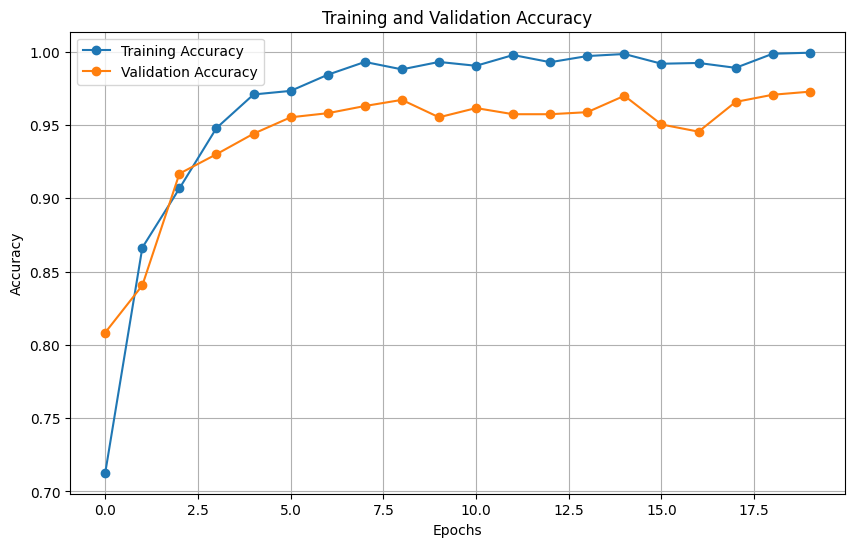

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(history.history["accuracy"], label="Training Accuracy", marker="o")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 13. Interactive Prediction System (Simulation)
Now that the model is trained, let's test it in a real-world scenario!
We use `ipywidgets` to create a simple user interface where you can upload an MRI image, and the model will diagnose it instantly.

### **How the Code Works (Step-by-Step):**

1.  **The Interface (`widgets.FileUpload`):**
    * Creates a button that allows you to select images from your local computer.
    * `accept="image/*"` ensures only image files can be uploaded.

2.  **Image Preprocessing (The `predict` function):**
    * **Loading:** Since the image comes as a raw byte stream from the upload, we use `BytesIO` to read it.
    * **Resizing:** We must force the image to be **224x224** because the model's input layer is fixed to this size.
    * **Normalization:** We divide by **255.0** manually (`x = x / 255.0`). *Critically important:* The model was trained on numbers between 0 and 1. If we feed it raw pixels (0-255), the predictions will be wrong.
    * **Batch Dimension:** The model expects a batch of images (e.g., shape `(32, 224, 224, 3)`). Even for a single image, we must add a fake dimension to make it `(1, 224, 224, 3)` using `np.expand_dims`.

3.  **Inference (`model.predict`):**
    * The model outputs 4 numbers (probabilities).
    * **`np.argmax`**: We pick the index of the highest number (e.g., if index 3 is highest, the class is "Pituitary").
    * **Confidence:** We display how sure the model is (e.g., 99.8%).

*Try uploading an MRI image now and see if the AI gets it right!*

In [15]:
uploader=widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out=widgets.Output()
display(out)


class_names = train_dir.class_names

def predict(filename, file, out):
  img=tf.keras.utils.load_img(file, target_size=img_size)
  X=tf.keras.utils.img_to_array(img)
  X = X / 255.0
  X = np.expand_dims(X, axis=0)

  prediction=model.predict(X, verbose=0)
  predicted_class_index=np.argmax(prediction)
  predicted_class=class_names[predicted_class_index]
  confidence=np.max(prediction)* 100

  with out:
   print(f"{filename} is mostly: {predicted_class} ({confidence:.2f}%)")

def on_upload_change(change):
    items = change.new
    if isinstance(items, list):
         for item in items:
            file_jpgdata = BytesIO(item["content"])
            predict(item["name"], file_jpgdata, out)
    else:
        for filename, item in items.items():
            file_jpgdata = BytesIO(item["content"])
            predict(filename, file_jpgdata, out)

uploader.observe(on_upload_change, names="value")

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()